In [1]:
import geopandas as gpd

shapefile = gpd.read_file("/kaggle/input/rzhd-hack/selected1.shp")
print(shapefile)

                    name                   geometry
0   Бекасово-Центральное  POINT (36.88475 55.40511)
1                 Перово  POINT (37.78648 55.75120)
2               Аэропорт  POINT (37.53315 55.80040)
3               Яничкино  POINT (37.85962 55.65347)
4                Красное  POINT (31.03734 54.68266)
..                   ...                        ...
64              Балашиха  POINT (37.94846 55.80955)
65        Льгов-Киевский  POINT (35.26924 51.63673)
66               Присады  POINT (37.81096 54.11987)
67               Ногинск  POINT (38.44357 55.85075)
68              Северная  POINT (37.61872 51.29396)

[69 rows x 2 columns]


In [2]:
import geopandas as gpd

# Load the shapefile
shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")

# Assuming the columns for origin, destination, and distance are named 'origin', 'destination', and 'distance'
# Separating geometry from other columns
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

# Aggregating non-geometry columns by summing the distances
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).sum().reset_index()

# Aggregating geometry columns by grouping and applying unary_union
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()

# Merging the aggregated non-geometry data with the aggregated geometry
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Converting to GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

# Print the result
print(aggregated_data)


                    origin                     destinatio        id  oneway  \
0       Александро-Невская                         Рыбное  10256132       0   
1   Бекасово-Сортировочное                        Вековка  41833615      60   
2   Бекасово-Сортировочное          Люблино-Сортировочное  24567225      37   
3   Бекасово-Сортировочное                  Малоярославец  14502759      33   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  12674521      21   
..                     ...                            ...       ...     ...   
75                   Унеча                       Стародуб   7738604       0   
76                 Фрязево                        Ногинск   3851760      15   
77                 Щёлково               Лосиноостровская  11262971       0   
78       Ярославль-Главный               Лосиноостровская  26472587      84   
79       Ярославль-Главный                  Орехово-Зуево  20633738      66   

                                             revers

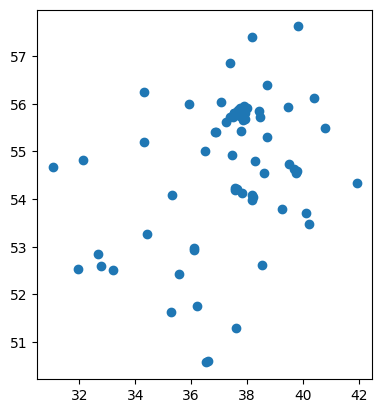

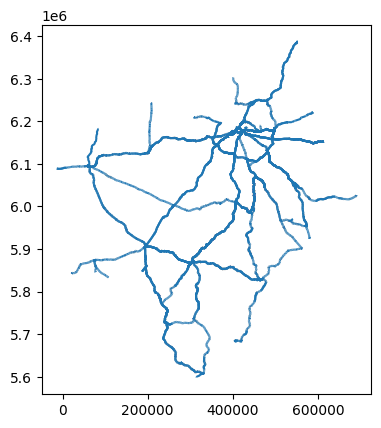

In [3]:
import matplotlib.pyplot as plt

shape2 = aggregated_data
shapefile.plot()
plt.show()

shape2.plot()
plt.show()


In [4]:
import geopandas as gpd

# Assuming your GeoDataFrame 'shapefile2' has a proper CRS set
# Calculate the length of each geometry in meters
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

# Print the result
print(aggregated_data[['origin','destinatio','geometry', 'length_km']])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  
2   MULTILINESTRING ((420474.245 6171937.324, 4204...  122.1712

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


In [7]:
import geopandas as gpd
import networkx as nx



In [8]:
all_routes = aggregated_data


# Create an empty graph
G = nx.Graph()

# Add nodes (stations) to the graph
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Add edges (routes) to the graph with distance as weight
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # Assuming undirected graph, add the reverse edge
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])

# Optional: If you have additional attributes like route type, you can add them as edge attributes too
# for index, row in all_routes.iterrows():
#     G[row['origin']][row['destination']]['route_type'] = row['route_type']


In [9]:
# Function to find shortest path between start and end stations
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found

# Example: Iterate over train_df to find optimal paths
for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = None  # or any default value for no path found
        train_df.at[index, 'num_stations'] = None

# Print updated train_df
print(train_df)



      index      value            route_start    route_end  \
0      1198   4.150000                Кусково     Яничкино   
1      2983  14.300000                Вековка        Курск   
2      3418   7.116667  Люблино-Сортировочное     Рязань-2   
3      1955  20.333333                Красное        Погар   
4      1697  13.900000               Белгород         Елец   
...     ...        ...                    ...          ...   
1514   2424  10.683333             Люберцы II  Волоколамск   
1515   1364   9.166667            Волоколамск      Вековка   
1516   1419  10.866667                 Перово         Елец   
1517   1723   9.483333            Волоколамск      Узуново   
1518   1006   6.466667               Рязань-2       Перово   

      optimal_distance_km  num_stations  
0              268.887101           2.0  
1             1166.548994           5.0  
2              314.678247           2.0  
3             2668.333561           7.0  
4              822.466978           4.0  
...

In [10]:
train_df["speed"] = train_df["optimal_distance_km"] / train_df["value"]

In [11]:
train_df["speed"].describe()

count    1360.000000
mean       80.476639
std        44.388520
min        19.508236
25%        57.650569
50%        67.698812
75%        90.286582
max       714.810571
Name: speed, dtype: float64

In [12]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [13]:
# Function to find shortest path between start and end stations
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found

# Example: Iterate over train_df to find optimal paths
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = None  # or any default value for no path found
        test_df.at[index, 'num_stations'] = None

# Print updated train_df
print(test_df)



      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  
0              757.835709           4.0  
1                     NaN           NaN  
2              438.417927           4.0  
3              433.693874  

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

# Assuming 'optimal_distance_km' is the target variable
X = train_df.drop(columns=['value', 'route_start', 'route_end', 'speed'])  # Features
y = train_df['value']  # Target variable

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Define CatBoost parameters
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 10,
    'loss_function': 'RMSE',
    'random_seed': 42
}

# Convert data to CatBoost Pool format
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

# Perform cross-validation
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5,  # Number of folds for cross-validation
                verbose=100,  # Print progress every 100 iterations
                plot=True)  # Plot training metrics

# Get best iteration
best_iteration = len(cv_results)  # Use the number of iterations where the best metric was achieved

print(f"Best RMSE: {cv_results['test-RMSE-mean'].min():.2f} ± {cv_results['test-RMSE-std'].mean():.2f} at iteration {best_iteration}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 11.0241685	test: 11.0889011	best: 11.0889011 (0)	total: 67.8ms	remaining: 1m 7s
100:	learn: 2.3384428	test: 2.8749325	best: 2.8440282 (64)	total: 616ms	remaining: 5.48s
200:	learn: 1.8911273	test: 2.9576876	best: 2.8440282 (64)	total: 1.22s	remaining: 4.87s
300:	learn: 1.6081349	test: 3.0034579	best: 2.8440282 (64)	total: 1.81s	remaining: 4.21s
400:	learn: 1.3954506	test: 3.0692315	best: 2.8440282 (64)	total: 2.42s	remaining: 3.61s
500:	learn: 1.2344564	test: 3.1067524	best: 2.8440282 (64)	total: 3.02s	remaining: 3.01s
600:	learn: 1.1118901	test: 3.1266484	best: 2.8440282 (64)	total: 3.61s	remaining: 2.4s
700:	learn: 1.0148374	test: 3.1400066	best: 2.8440282 (64)	total: 4.23s	remaining: 1.8s
800:	learn: 0.9283742	test: 3.1559942	best: 2.8440282 (64)	total: 4.87s	remaining: 1.21s
900:	learn: 0.8537218	test: 3.1712645	best: 2.8440282 (64)	total: 5.49s	remaining: 604ms
999:	learn: 0.7984685	test: 3.1915437	best: 2.8440282 (64)	total: 6.12s	remaining: 0us



In [16]:
# Initialize CatBoostRegressor with best parameters
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=10,
                               loss_function='RMSE',
                               random_seed=42)

# Fit model on entire training data
best_model.fit(X, y, verbose=100)  # Verbose to see progress every 100 iterations

0:	learn: 4.3629125	total: 7.34ms	remaining: 7.33s
100:	learn: 2.3784499	total: 492ms	remaining: 4.38s
200:	learn: 2.0189467	total: 1.01s	remaining: 4.03s
300:	learn: 1.7986002	total: 1.6s	remaining: 3.71s
400:	learn: 1.6383120	total: 2.12s	remaining: 3.16s
500:	learn: 1.5063901	total: 2.63s	remaining: 2.62s
600:	learn: 1.4011159	total: 3.17s	remaining: 2.1s
700:	learn: 1.3118410	total: 3.7s	remaining: 1.58s
800:	learn: 1.2388368	total: 4.22s	remaining: 1.05s
900:	learn: 1.1789800	total: 4.75s	remaining: 522ms
999:	learn: 1.1274715	total: 5.28s	remaining: 0us


In [17]:
# Predict on test data
y_pred = best_model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} kilometers")
print(f"MAE: {mae:.2f} kilometers")


RMSE: 1.42 kilometers
MAE: 0.76 kilometers


In [18]:
# Assuming 'test_df' has similar structure as 'train_df' without 'optimal_distance_km'
test_pred = best_model.predict(test_df.drop(columns=['route_start', 'route_end']))

# Print or use 'test_pred' as needed for your application
print(test_pred)

[10.89952271 10.54421412  9.49124487 ... 10.54314671 12.25671874
  6.23584733]


In [19]:
test_df["value"] = test_pred

In [20]:
test_df

,index,route_start,route_end,optimal_distance_km,num_stations,value
0,2623,Вязьма,Щёлково,757.835709,4.0,10.899523
1,4413,Аэропорт,Лесок,NaN,NaN,10.544214
2,480,Узуново,Малоярославец,438.417927,4.0,9.491245
3,4409,Серпухов,Лесок,433.693874,3.0,7.351324
4,9286,Кунцево II,Петушки,716.954299,5.0,11.967232
...,...,...,...,...,...,...
1514,1676,Елец,Перово,NaN,NaN,9.307269
1515,8047,Зелёный Бор,Вековка,454.405937,3.0,6.831107
1516,37,Москва-Товарная-Смоленская,Курбакинская,703.990153,4.0,10.543147
1517,1179,Смоленск-Сортировочный,Владимир,941.980834,4.0,12.256719
